# (11.1) Application of filter with new distance

In this notebook we use the new objective function $D_{new} = D_{HD}\times D_{euc}$ in combination with the averaging filter designed in notebook 10. The filter width will be chosen so that the autocorrelation function of the artificial experimental lineage is $1/e$.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## First attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\alpha_0 = 5.0$, $\alpha_1 = 0.3$, $\beta_0 = 1.0$ and $\beta_1 = 0.5$:

In [4]:
true_par = [5.0,0.3,1.0,0.5];

In [5]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data::Array{Array{Float64,1},1}, inf_par::Array{Float64,1}, ics::Array{Any,1}) # arguments are wrt each lineage.
    SSA_data_c = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        push!(SSA_data_c, ssa[2][:]);
    end
    return convert(Array{Array{Float64,1},1},SSA_data_c) # return 
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [6]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1]);

Let's plot this data:

In [7]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings, StatsBase, Statistics, LinearAlgebra; pyplot()

Plots.PyPlotBackend()

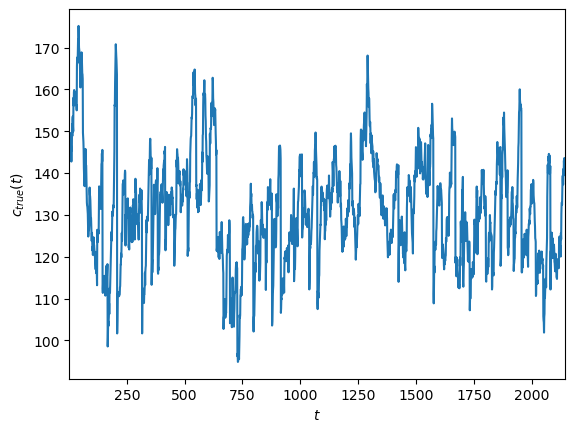

In [8]:
PyPlot.plot(range(1,length(vcat(expt_ssa_conc...)[:]),step=1),vcat(expt_ssa_conc...)[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(vcat(expt_ssa_conc...)[:])]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.


0.9899999999999998

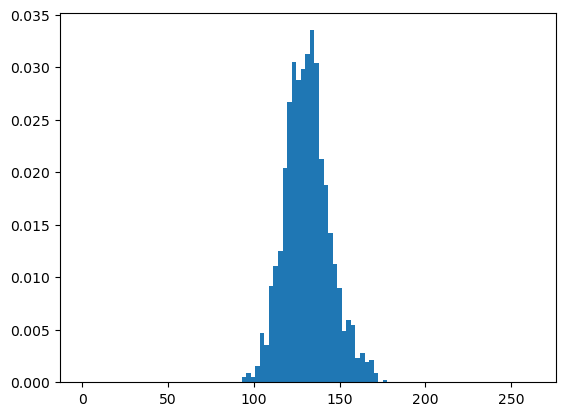

In [9]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0.0, maximum(vcat(expt_ssa_conc...)[:])*1.5, 100);
true_bin_vals, other_stuff = ax.hist(vcat(expt_ssa_conc...)[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals*(maximum(vcat(expt_ssa_conc...)[:])*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

Now let's look at the autocorrelation function of the lineage.

In [10]:
using StatsBase;

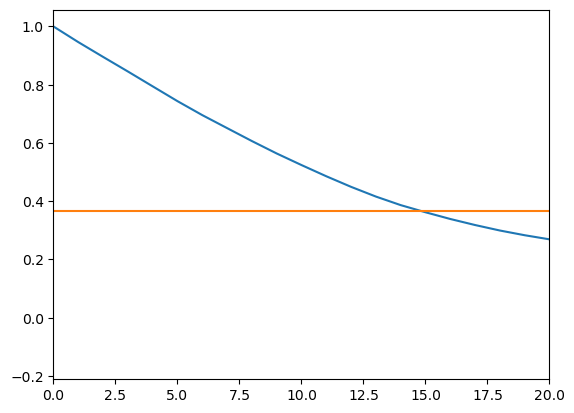

In [11]:
expt_ac = autocor(vcat(expt_ssa_conc...)[:], range(0, length(vcat(expt_ssa_conc...)[:])-1, step=1), demean = true);
fig, ax = PyPlot.subplots(1,1, sharex = true);
ax.plot(expt_ac); ax.plot(ones(length(expt_ac)).* exp(-1)); ax.set_xlim(0,20);

Clearly this is not reasonable. Let's choose $n = 4$ and plot the filtered experimental SSA lineage.

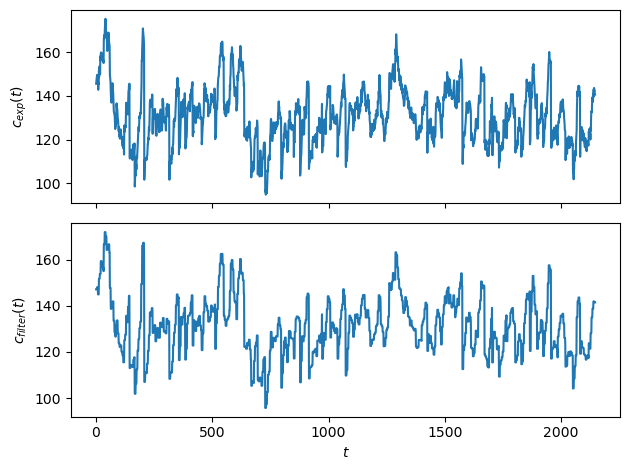

In [170]:
n = 4;

lin_expt = vcat(expt_ssa_conc...); filter_expt = filter_lin(expt_ssa_conc, n)[2]
filter_expt_form = hcat(filter_expt);

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{filter}(t)"); 
axs[1].plot(range(1,length(lin_expt),step=1),lin_expt); axs[2].plot(range(1,length(filter_expt),step=1),filter_expt);

In [159]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params::Array{Float64,1})
    lin_conc = filter_lin(Single_lin(lineage_data, var_params, lin_ic)[:], n)[2] # choose up-sep form [2]
    return hcat(lin_conc)::Array{Float64,2}
end

simulator_function_conc (generic function with 1 method)

Create the new distance function that takes in the sample trajectory vector and experimental trajectory as inputs and outputs the product of the hellinger distance and the euclidean distance between the two trajectories.

In [160]:
function new_distance(samp_traj::Array{Float64,1}, exp_traj::Array{Float64,1})
    euc_dist = euclidean(samp_traj[:], exp_traj[:]); # euclidean distance
    samp_bins = normalize(fit(Histogram, samp_traj[:], mod_bins), mode=:probability).weights;
    exp_bins = normalize(fit(Histogram, exp_traj[:], mod_bins), mode=:probability).weights;
    hell_dist = hellinger(samp_bins, exp_bins); # HD
    
    return euc_dist*hell_dist::Float64 # return the product
end

new_distance (generic function with 1 method)

In [161]:
thres_cutoff = sum(new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:]) for i in 1:1000)/1000

66.03432952183275

In [169]:
@time new_distance(simulator_function_conc(true_par)[:], filter_expt_form[:])

  0.008103 seconds (22.95 k allocations: 2.003 MiB)


64.37538191989117

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 48/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 97/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 140/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 194/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 239/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 288/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection si

┌ Info: GpABC SMC simulation accepted 824/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 863/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 900/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 954/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 100.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 43/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 81/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 134/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR

┌ Info: GpABC SMC simulation accepted 973/38000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 70.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 25/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 55/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 71/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 96/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 122/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 148/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/sr

┌ Info: GpABC SMC simulation accepted 563/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 590/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 609/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 616/26000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 641/27000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 661/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 692/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 714/30000 particles.
└ @ GpABC /home/s1402978

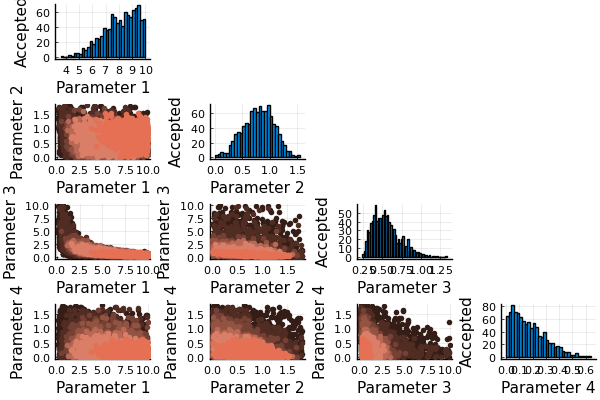

In [171]:
n_particles = 1000;
threshold_schedule = [500.0, 250.0, 150.0, 100.0, 80.0, 70.0, 65.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053"]#,"#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

In [172]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 8.241086427073727
 0.8085200496677027
 0.5233407617205565
 0.15170630908582114

In [173]:
true_par

4-element Array{Float64,1}:
 5.0
 0.3
 1.0
 0.5

Print the differences.

In [174]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
  3.2410864270737267
  0.5085200496677027
 -0.47665923827944345
 -0.34829369091417883

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

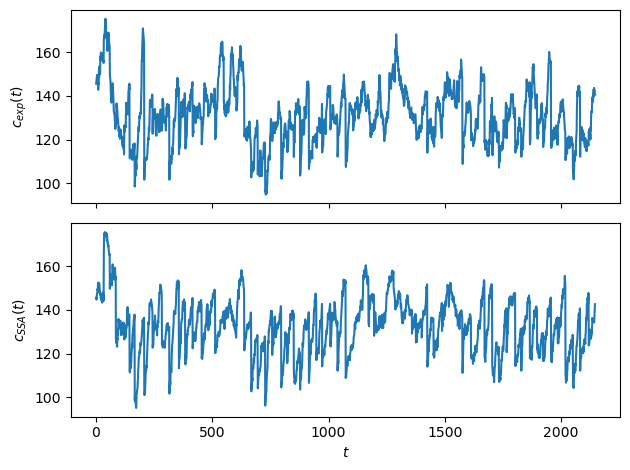

  0.015953 seconds (45.84 k allocations: 4.263 MiB)


In [175]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = vcat(single[1:length(single)]...)[:]; expt_c = vcat(expt_ssa_conc...)[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

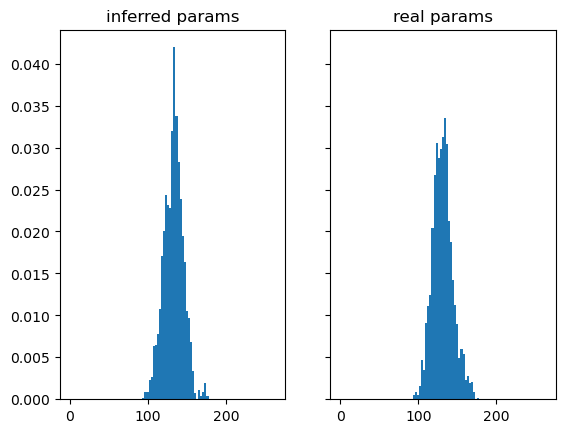

Hellinger distance between these is: 0.1300734359179609

In [176]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_c[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.

## Run them again!

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 48/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 101/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 149/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 200/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 262/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 320/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection s

┌ Info: GpABC SMC simulation ϵ = 100.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 43/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 92/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 137/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 180/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 217/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 267/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 322/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/

┌ Info: GpABC SMC simulation accepted 26/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 49/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 79/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 106/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 130/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 153/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 179/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 208/8000 particles.
└ @ GpABC /home/s1402978/.julia/pac

┌ Info: GpABC SMC simulation accepted 485/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 507/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 528/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 547/26000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 567/27000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 588/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 602/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 613/30000 particles.
└ @ GpABC /home/s1402978

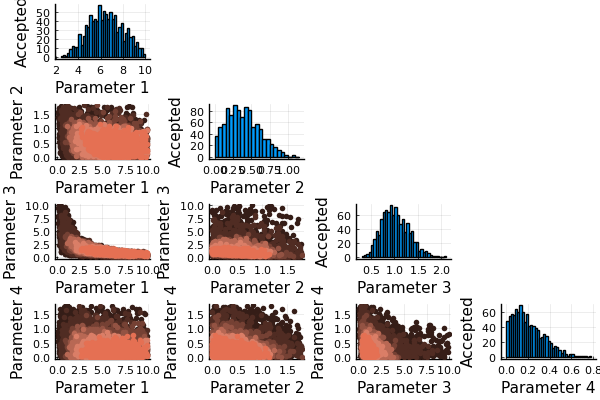

In [177]:
n_particles = 1000;
threshold_schedule = [500.0, 250.0, 150.0, 100.0, 80.0, 70.0, 65.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

In [178]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 6.406738630942437
 0.37151641743770514
 0.987812190590269
 0.1747463643066638

In [179]:
true_par

4-element Array{Float64,1}:
 5.0
 0.3
 1.0
 0.5

Print the differences.

In [180]:
diff_2 = (pars_conc_2 - true_par)

4-element Array{Float64,1}:
  1.4067386309424368
  0.07151641743770515
 -0.012187809409730965
 -0.3252536356933362

┌ Info: GpABC rejection simulation. ϵ = 500.0.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 54/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 102/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 152/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 194/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 242/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 304/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection s

┌ Info: GpABC SMC simulation accepted 278/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 300/20000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 312/21000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 329/22000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 342/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 365/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 377/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 394/26000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 912/31000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 939/32000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 973/33000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 80.0
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 27/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 46/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 69/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 90/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/

┌ Info: GpABC SMC simulation accepted 662/23000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 696/24000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 721/25000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 748/26000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 787/27000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 822/28000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 855/29000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 888/30000 particles.
└ @ GpABC /home/s1402978

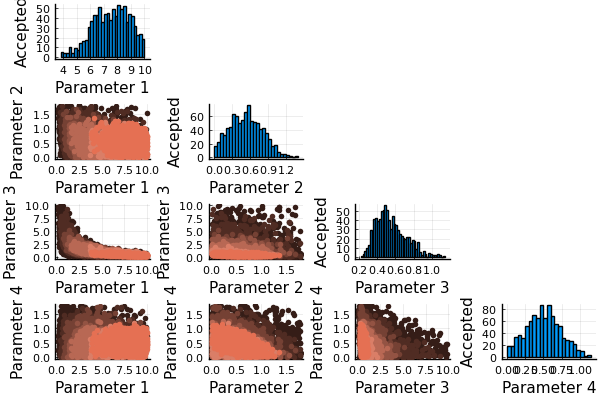

In [181]:
n_particles = 1000;
threshold_schedule = [500.0, 250.0, 150.0, 100.0, 80.0, 70.0, 65.0];

priors = [Uniform(0, 10.0), Uniform(0.0, 1.8), Uniform(0, 10.0),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_3 = SimulatedABCSMC(filter_expt_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = new_distance,
    max_iter = convert(Int,5E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_3, population_colors=population_colors)

In [182]:
pars_conc_3 = [median(sim_abcsmc_res_conc_3.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 7.614209203410708
 0.5200621877426711
 0.520189999845482
 0.496955509021759

In [183]:
true_par

4-element Array{Float64,1}:
 5.0
 0.3
 1.0
 0.5

Print the differences.

In [184]:
diff_3 = (pars_conc_3 - true_par)

4-element Array{Float64,1}:
  2.6142092034107076
  0.2200621877426711
 -0.479810000154518
 -0.003044490978240999

## Summary of results

The model that we are attempting to infer the parameter for is:
$$\varnothing \xrightarrow{a_1(t)}m\, P\xrightarrow{d}\varnothing,$$
where $a_1(t) = \alpha_0 V(t)^{\alpha_1}$ and $m$ is a random number drawn from a geometric distribution with time-dependent mean burst size $b(t) = \beta_0 V(t)^{\beta_1}$ and degradation rate $d = 0$. The volume of the system grows according to exponential growth law: $V(t) = V_0 e^{\theta t}$. Later on in this sheet we also go onto assess the minimum threshold for the SMC-ABC data. 

Let's see the inferred medians of the posterior distributions in some tables.

In [185]:
using DataFrames;

In [186]:
par_conc = convert(Array{Float64,2},transpose([true_par pars_conc_1 pars_conc_2 pars_conc_3]));
df_conc = DataFrame(alpha_0 = par_conc[:,1], alpha_1 = par_conc[:,2], beta_0 = par_conc[:,3], beta_1 = par_conc[:,4]);

In [187]:
df_conc

,alpha_0,alpha_1,beta_0,beta_1
,Float64,Float64,Float64,Float64
1,5.0,0.3,1.0,0.5
2,8.24109,0.80852,0.523341,0.151706
3,6.40674,0.371516,0.987812,0.174746
4,7.61421,0.520062,0.52019,0.496956
